In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd  'drive/MyDrive/Colab Notebooks/crude-oil-forecast'

In [1]:
#%%

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# !pip install pmdarima
import pmdarima as pm
import plotly.express as px
import plotly.graph_objects as go
# import requests
from plotly.subplots import make_subplots
from pmdarima.arima.utils import nsdiffs,ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
# import mlflow

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
# %matplotlib inline

In [2]:
#%%

# Configure logging to print to standard output
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Now, logging.info will print to the notebook
logging.info("Modeling and Forecasting Brent Crude Oil Using ARIMA ")

def load_data():
    file_path = 'Modified_Data.csv'
    # url = 'https://raw.githubusercontent.com/jnopareboateng/ml-library/master/crude-oil-forecast/Modified_Data.csv'
    # response = requests.get(url)
    # response.raise_for_status()
    data = pd.read_csv(file_path, parse_dates=True, index_col=[0])
    return data

Modeling and Forecasting Brent Crude Oil Using ARIMA 


In [3]:
#%%

def plot_data(data):
    data_plot = px.line(data, x=data.index, y=data['Price'], title="Brent Crude Oil Prices from 2002 -2022")
    decomposition = seasonal_decompose(data["Price"], model="additive")
    decomposition.plot()
    plt.savefig('data_visualization.png')
    return data_plot

In [4]:
#%%

def test_stationarity(series):
    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        logging.info(f'ADF Statistic: {result[0]}')
        logging.info(f'p-value: {result[1]}')
        if result[1] <= 0.05:
            logging.info("Data is likely stationary.")
        else:
            logging.info("Data may be non-stationary. Consider differencing.")

    logging.info("""Testing stationarity of data:""")
    adf_test(series)

In [5]:
#%%

def preprocess_data(data):
    n_diffs = pm.arima.ndiffs(data['Price'], test='adf')
    logging.info(f"\nNumber of differences required : {n_diffs}")
    if n_diffs > 0:
        differenced_data = data.diff(n_diffs).dropna()
    else:
        differenced_data = data.copy()
    return differenced_data

In [6]:
#%%

def plot_differenced_data(differenced_data):
    differenced_data.plot()
    plt.savefig('differenced_data.png')

In [7]:
#%%

def check_seasonal_differencing(data):
    nsdiff= nsdiffs(data['Price'], m=12, test='ch')
    logging.info(f"Seasonal differences required: {nsdiff}")

In [8]:
#%%

def plot_seasonal_decomposition(differenced_data):
    decomposition = seasonal_decompose(differenced_data["Price"], model="additive")
    decomposition.plot()
    plt.savefig('seasonal_decomposition.png')

In [9]:
#%%

def plot_acf_pacf_plots(differenced_data):
    plot_acf(differenced_data['Price'], title='ACF Plot')
    plt.savefig('acf_plot.png')
    plot_pacf(differenced_data['Price'], title='PACF Plot')
    plt.savefig('pacf_plot.png')

In [10]:
#%%

def plot_seasonal_data(data):
    df_2002 = data['2002']
    df_2003 = data['2003']
    df_2004 = data['2004']
    df_2005 = data['2005']
    df_2006 = data['2006']
    df_2007 = data['2007']
    fig = make_subplots(rows=6, cols=1)
    fig.add_trace(go.Scatter(x=df_2002.index, y=df_2002['Price'], name='Price in 2002'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_2003.index, y=df_2003['Price'], name='Price in 2003'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_2004.index, y=df_2004['Price'], name='Price in 2004'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df_2005.index, y=df_2005['Price'], name='Price in 2005'), row=4, col=1)
    fig.add_trace(go.Scatter(x=df_2006.index, y=df_2006['Price'], name='Price in 2006'), row=5, col=1)
    fig.add_trace(go.Scatter(x=df_2007.index, y=df_2007['Price'], name='Price in 2007'), row=6, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=3, col=1)
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_xaxes(title_text="Date", row=5, col=1)
    fig.update_xaxes(title_text="Date", row=6, col=1)
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Price", row=2, col=1)
    fig.update_yaxes(title_text="Price", row=3, col=1)
    fig.update_yaxes(title_text="Price", row=4, col=1)
    fig.update_yaxes(title_text="Price", row=5, col=1)
    fig.update_yaxes(title_text="Price", row=6, col=1)
    fig.update_layout(height=1000, title_text="Price from 2002 to 2007")
    fig.show()

In [11]:
#%%

def evaluate_stationarity(differenced_data):
    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        logging.info(f'ADF Statistic: {result[0]}')
        logging.info(f'p-value: {result[1]}')
        if result[1] <= 0.05:
            logging.info("Data is likely stationary.")
        else:
            logging.info("Data may be non-stationary. Consider differencing.")

    logging.info("Testing stationarity of scaled training data:")
    adf_test(differenced_data['Price'])

In [12]:
#%%

def auto_arima_model(differenced_data):
    model = pm.auto_arima(data['Price'], trace=True)
    logging.info(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
    logging.info(f'model order: {model.order}, \nmodel seasonal order: {model.seasonal_order}')
    return model

In [13]:
#%%

def plot_residuals(model):
    model.plot_diagnostics(figsize=(12, 8))
    plt.savefig('residuals_plot.png')

In [14]:
#%%

def fit_sarimax_model(differenced_data, order, seasonal_order):
    model = SARIMAX(endog=differenced_data, order=order, seasonal_order=seasonal_order, freq="MS")
    results = model.fit(disp=0)
    logging.info(results.summary())
    return results

In [15]:
#%%

def forecast_future_values(history, order, seasonal_order, horizon):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    history = data['Price']
    horizon = 24
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=horizon)
    forecast_period = pd.date_range(start=history.index[-1], periods=horizon+1, freq='MS')[1:]
    predictions = pd.Series(predictions, index=forecast_period)
    forecast_90 = model_fit.get_forecast(steps=horizon)
    forecast_summary_90 = forecast_90.summary_frame(alpha=0.10)
    forecast_95 = model_fit.get_forecast(steps=horizon)
    forecast_summary_95 = forecast_95.summary_frame(alpha=0.05)
    plt.plot(history.index, history, label='Historical Data')
    plt.plot(predictions.index, predictions, color='red', label='Forecasted Values')
    plt.fill_between(forecast_summary_90.index,
                     forecast_summary_90['mean_ci_lower'],
                     forecast_summary_90['mean_ci_upper'], color='pink', alpha=0.1, label='90% Confidence Interval')
    plt.fill_between(forecast_summary_95.index,
                     forecast_summary_95['mean_ci_lower'],
                     forecast_summary_95['mean_ci_upper'], color='blue', alpha=0.05, label='95% Confidence Interval')
    plt.title('Forecast with Confidence Intervals')
    plt.legend()
    plt.savefig('forecast_with_confidence_intervals.png')
    return predictions, forecast_summary_90, forecast_summary_95

def plot_forecast_with_confidence_intervals(history, predictions, forecast_summary_90, forecast_summary_95):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=history.index, y=history, mode='lines', name='Historical Data'))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name='Forecasted Values'))
    fig.add_trace(go.Scatter(x=forecast_summary_90.index, y=forecast_summary_90['mean_ci_upper'], mode='lines', name='90% Confidence Interval', line=dict(width=0)))
    fig.add_trace(go.Scatter(x=forecast_summary_90.index, y=forecast_summary_90['mean_ci_lower'], mode='lines', name='90% Confidence Interval', line=dict(width=0), fill='tonexty'))
    fig.add_trace(go.Scatter(x=forecast_summary_95.index, y=forecast_summary_95['mean_ci_upper'], mode='lines', name='95% Confidence Interval', line=dict(width=0)))
    fig.add_trace(go.Scatter(x=forecast_summary_95.index, y=forecast_summary_95['mean_ci_lower'], mode='lines', name='95% Confidence Interval', line=dict(width=0), fill='tonexty'))
    fig.update_layout(title='Forecast with Confidence Intervals')
    fig.show()

In [16]:
#%%

def calculate_error_metrics(data, predictions):
    data= data[-len(predictions):]
    mae = mean_absolute_error(data, predictions)
    mape = mean_absolute_percentage_error(data, predictions)
    logging.info("""Evaluating with MAE and MAPE """)
    logging.info(f"Mean Absolute Error: {mae}")
    logging.info(f"Mean Absolute Percentage Error: {mape}")

Testing stationarity of data:
ADF Statistic: -2.883602424447067
p-value: 0.04728831004955812
Data is likely stationary.

Number of differences required : 1
Seasonal differences required: 0


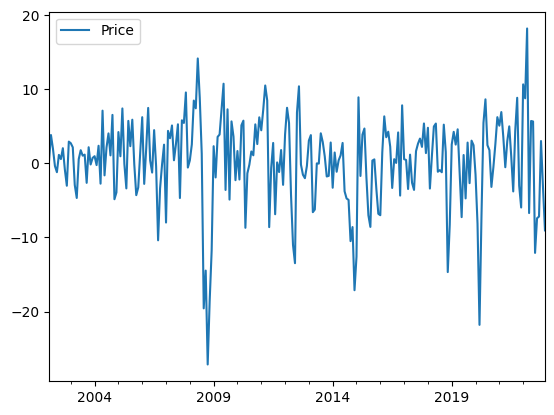

In [17]:
#%%
data = load_data()
test_stationarity(data)
differenced_data = preprocess_data(data)

plot_differenced_data(differenced_data)
check_seasonal_differencing(data)

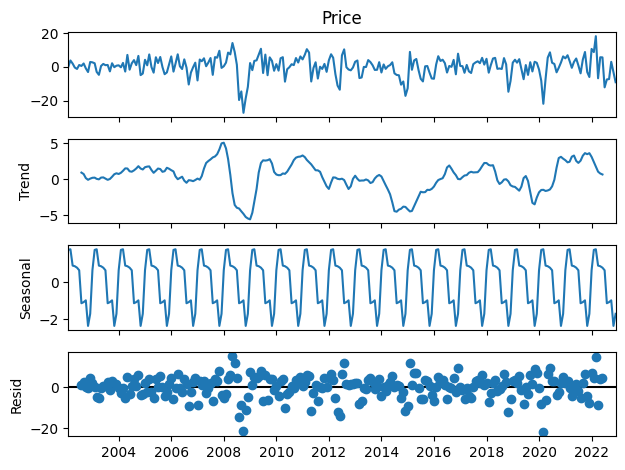

In [18]:
plot_seasonal_decomposition(differenced_data)

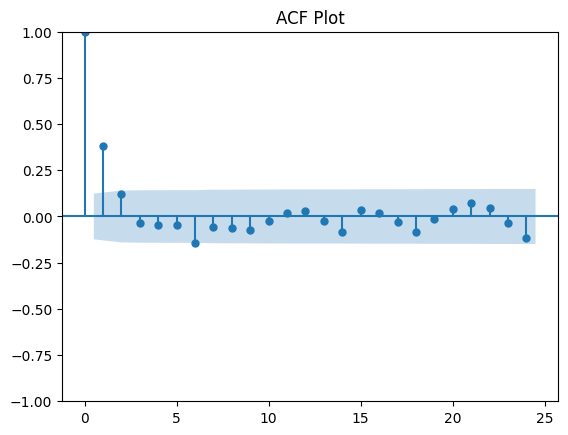

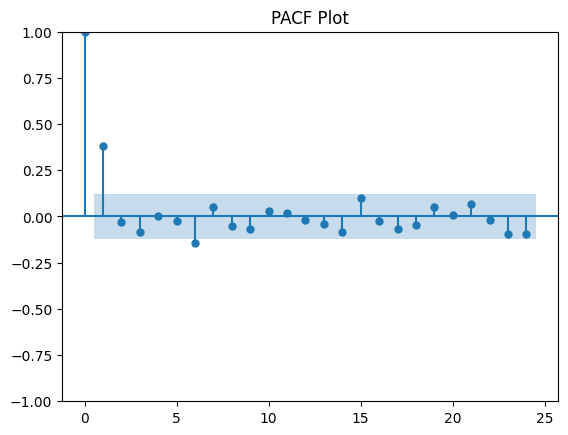

In [19]:
plot_acf_pacf_plots(differenced_data)


In [20]:
#%%
# plot_seasonal_data(data)
evaluate_stationarity(differenced_data)

Testing stationarity of scaled training data:
ADF Statistic: -10.452416485113096
p-value: 1.426848496782211e-18
Data is likely stationary.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1578.236, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1612.420, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1575.066, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1579.935, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1610.842, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1576.870, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1576.932, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1575.145, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1573.222, Time=0.02 sec



Auto ARIMA identified parameters: (1, 1, 0), (0, 0, 0, 0)
model order: (1, 1, 0), 
model seasonal order: (0, 0, 0, 0)


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1575.037, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1575.095, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1578.181, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1573.727, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.842 seconds


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  251
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -816.609
Date:                Mon, 13 May 2024   AIC                           1637.218
Time:                        16:17:31   BIC                           1644.261
Sample:                    02-01-2002   HQIC                          1640.053
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2883      0.060     -4.785      0.000      -0.406      -0.170
sigma2        40.2316      2.658     15.137      0.000      35.022      45.441
Ljung-Box (L1) (Q):                   0.68   Jarque-

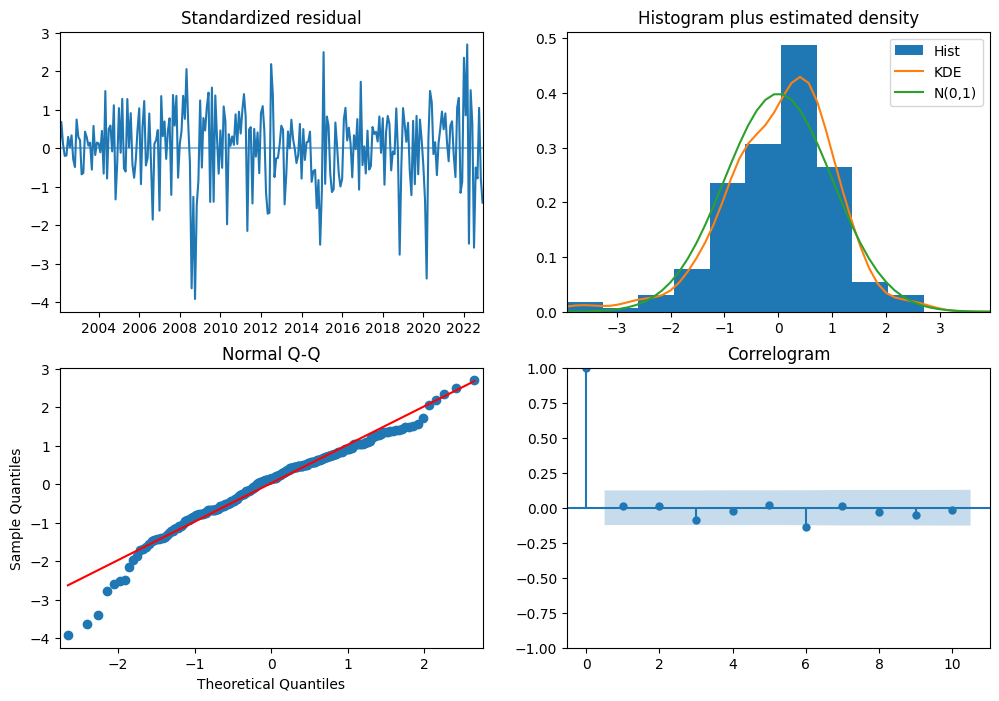

In [21]:
#%%

model = auto_arima_model(differenced_data)
plot_residuals(model)
results = fit_sarimax_model(differenced_data, model.order, model.seasonal_order)

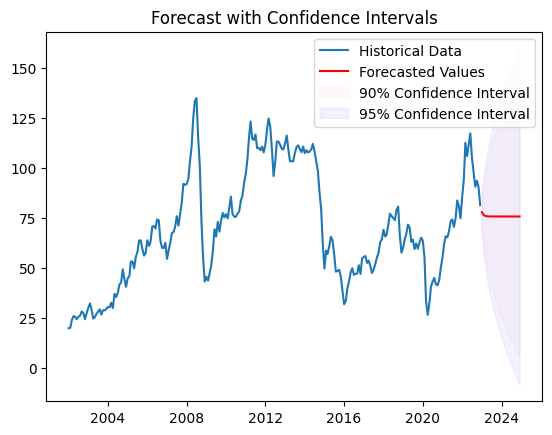

In [22]:
#%%

# Capture the returned values from forecast_future_values
predictions, forecast_summary_90, forecast_summary_95 = forecast_future_values(data['Price'], model.order, model.seasonal_order, 24)

# Now you can use 'predictions' in the following functions
plot_forecast_with_confidence_intervals(data['Price'], predictions, forecast_summary_90, forecast_summary_95)

In [23]:
calculate_error_metrics(data['Price'], predictions)

Evaluating with MAE and MAPE 
Mean Absolute Error: 15.239834376930796
Mean Absolute Percentage Error: 0.16906506436708
